In [1]:
import pandas as pd
import numpy as np
import glob
import datetime
%config IPCompleter.use_jedi=False

from sklearn.model_selection import train_test_split

In [2]:
savepath = r"Data/data_cleaned.csv"

## IDEAS

First split into train,validation,and Test before even plotting the data.
(How large should each data set be?)
Only plot training data, neve rlook at test data! Otherwise my your knowledge of test data biases test error estimates.

Is data set "Balanced"? Should I try to preserve some balance in train, val, test split?
-> Subscribers make MANY more trips

Remove outliers from triptime and birthyear data

1. Load all files into one data frame grouped by month -> Can pandas even do this?
2. Split Data -> I do one fixed train,test,validation split at the beginning and never change it because the data set is very large and I dont expect much variation over splits. I could otherwise do corss-validation or something. Question: Should one balance labels somehow in the splits?
3. Compute trip durations -> already done, and length (how??? luftlinie oder station distances -> Google maps API?) from the data
    1. Can use OSMnx
    2. Use Taxicab metric (simpler) -> Actually not simpler at all, need coordinates relative to new york layout
    3. Luftlinie (am einfachsten)
4. Compute weekdays vs weekends
5. Can one do somethign with bikeID?
6. Can one do something with stationID?
7. Compare to baseline of simply choosing most likely class label, ignoring user data!
   Or use other ways of dealing with imbalance / representing effect?

Features need to be preprocessed -> Encode categorically etc.

Some feature ideas:
1. Time
2. Distance
3. Speed
4. Workday vs Weekend (maybe even include holidays)
5. Month (maybe)
6. StartStation -> Because people from similar areas might be subscribers / not 

Map of stations: https://account.citibikenyc.com/map

## Evaluation?

1. Evaluate vs baseline (baseline = always choose "subscriber" as label)
2. Confusion matrix

## Data Formatting

Try loading the whole dataset. Note that this needs more than 9 GB of memory.

We first do some preprocessing on the time columns because they are very large and formatted as strings.

In [38]:
def load_files(filenames, cols=None,dtype=None):
    dfs=[]
    for filename in filenames:
        d = pd.read_csv(filename,usecols=cols,dtype=dtype)
        dfs.append(d)
    data = pd.concat(dfs,ignore_index=True)
    data = data.astype(dtype,copy=False) #Because categorical dtypes are not preserved under concatenation
    return data

In [4]:
filenames = glob.glob("Data/2*.csv")
print(filenames)

['Data/201810-citibike-tripdata.csv', 'Data/201802-citibike-tripdata.csv', 'Data/201809-citibike-tripdata.csv', 'Data/201808-citibike-tripdata.csv', 'Data/201803-citibike-tripdata.csv', 'Data/201807-citibike-tripdata.csv', 'Data/201812-citibike-tripdata.csv', 'Data/201805-citibike-tripdata.csv', 'Data/201811-citibike-tripdata.csv', 'Data/201806-citibike-tripdata.csv', 'Data/201804-citibike-tripdata.csv', 'Data/201801-citibike-tripdata.csv']


In [5]:
def strtodatetime(s):
    """
    Take a string in the format of the data  set and return datetime information
    """
    s = s.split(".")[0]
    d=datetime.datetime.strptime(s,"%Y-%m-%d %H:%M:%S")
    return d.month,d.day, d.hour, d.minute, d.weekday()

In [ ]:
data=load_files(filenames,cols=["starttime"])

In [18]:
new = data.apply(lambda row: strtodatetime(row["starttime"]),axis=1,result_type="expand")
new.columns=["month", "start day", "start hour", "start minute", "start weekday"]
new.to_csv("Data/starttimes.csv")
del new
del data

In [8]:
data=load_files(filenames,cols=["stoptime"])

In [10]:
new = data.apply(lambda row: strtodatetime(row["stoptime"]),axis=1,result_type="expand")
print("Data processed")
new.columns=["stop month", "stop day", "stop hour", "stop minute", "stop weekday"]
new.to_csv("Data/stoptimes.csv")

Data processed


In [11]:
del new
del data

Now we build one big data frame with appropriate dtypes and save it for later convenience.

In [27]:
dtypes = {"tripduration":"Int64", #Note that this accepts nan values
          "start station id":"Int64",
          "start station name":"category",
          "start station latitude":"Float64",
          "start station longitude":"Float64",
          "end station id":"Int64",
          "end station name":"category",
          "end station latitude":"Float64",
          "end station longitude":"Float64",
          "bikeid":"Int64",
          "usertype":"category",
          "birth year":"Int64",
          "gender":"category"}

In [39]:
data = load_files(filenames,cols=lambda x: x not in ["starttime","stoptime"],dtype=dtypes)

In [40]:
data.memory_usage(deep=True)

Index                            128
tripduration               157935051
start station id           157935051
start station name          35193105
start station latitude     157935051
start station longitude    157935051
end station id             157935051
end station name            35195371
end station latitude       157935051
end station longitude      157935051
bikeid                     157935051
usertype                    17548579
birth year                 157935051
gender                      17548621
dtype: int64

In [41]:
data.dtypes

tripduration                  Int64
start station id              Int64
start station name         category
start station latitude      Float64
start station longitude     Float64
end station id                Int64
end station name           category
end station latitude        Float64
end station longitude       Float64
bikeid                        Int64
usertype                   category
birth year                    Int64
gender                     category
dtype: object

In [42]:
memory = data.memory_usage(index=True,deep=True).sum()
print(f"The dataframe needs {memory/1e9:.3} GB of memory")

The dataframe needs 1.53 GB of memory


In [60]:
starttimes = pd.read_csv("Data/starttimes.csv")
starttimes.drop("Unnamed: 0",axis=1,inplace=True) # Because I accidentally wrote an index column before
stoptimes = pd.read_csv("Data/stoptimes.csv")
stoptimes.drop("Unnamed: 0",axis=1,inplace=True)
stoptimes.drop("stop month",axis=1,inplace=True)

In [ ]:
data_new = pd.concat((data,starttimes),axis=1)
data_new = pd.concat((data_new,stoptimes),axis=1)
data_new

We now look at the some features and try to remove outliers.

First, lets check for NAN values:

In [5]:
data.count()

tripduration               17548339
starttime                  17548339
stoptime                   17548339
start station id           17545842
start station name         17545842
start station latitude     17548339
start station longitude    17548339
end station id             17545842
end station name           17545842
end station latitude       17548339
end station longitude      17548339
bikeid                     17548339
usertype                   17548339
birth year                 17548339
gender                     17548339
month                      17548339
dtype: int64

We see that start and end station ids and names are not always available.
This affects about 3000 of the 17 million entries.
We simply remove the rows with missing values.

In [6]:
data.dropna(inplace=True)
print(len(data))
data.count()

17545842


NameError: name 'data_cleaned' is not defined

Now, we check for outliers in the different features.
Let us start with trip durations.
We plot a histogram of the tripdurations to understand the distributions.
Because there are some very large values, we use a loglog-scale.
Note that the bins should be spaced evenly on a log-scale and not on a linear scale, so we specify them manually.

Text(0.5, 0, 'Duration (s)')

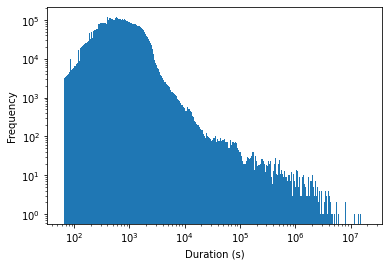

In [7]:
min_dur = data["tripduration"].min()
max_dur = data["tripduration"].max()
n_bins = 1000
bins = np.logspace(start = np.log10(min_dur),stop = np.log10(max_dur),num=n_bins)
ax = data["tripduration"].plot(kind="hist",loglog=True,bins=bins)
ax.set_xlabel("Duration (s)")

In [20]:
1e7 / (60*60*24)

115.74074074074075

Most trips are between 2 mins and 1 hour.
We remove trip durations > 5 hours, which is about $2\cdot10^4$ seconds.
Also note that durations < 60 seconds were already removed by the data provider, reasoning that these are likely just people trying to redock the bike. Therefore, we will not remove any more small trip lengths.

In [8]:
duration_h = 5
longtrips = data[data["tripduration"] >= duration_h*60*60]
print(f"There are {len(longtrips)} trips of at least {duration_h} hours in the data.")
data.drop(longtrips.index,inplace=True)

There are 15454 trips of at least 5 hours in the data.


Next, lets have a look at the birthyears.

In [9]:
print(data["birth year"].min())
print(data["birth year"].max())

1885
2002


We will exclude people born before 1920, since the data is from 2018.

In [11]:
old = data[data["birth year"] <= 1920]
print(f"There are {len(old)} trips made by people born before 1920 in the data.")
data.drop(old.index,inplace=True)

There are 181920 trips made by people born before 1920 in the data.


Next, we look at the coordinates.
New york encompasses latitudes of about between 40.6 and 40.9, and longitudes between -74.2 and -73.7

In [26]:
print(data["start station latitude"].min())
print(data["start station latitude"].max())

40.64653836709648
45.506364054011385


<AxesSubplot:ylabel='Frequency'>

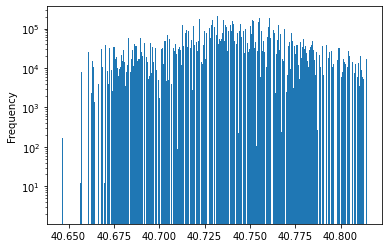

In [52]:
data["start station latitude"].plot(kind="hist",logy = True,bins=600)

There appear to be around a 100 bikes lost at latitude > 45, which is somewhere around Montreal.
We exclude these.

In [41]:
lost = data[data["start station latitude"]>41]
print(len(lost))
data.drop(lost.index,inplace=True)

75


In [43]:
print(data["end station latitude"].min())
print(data["end station latitude"].max())

40.64653836709648
40.814394437915816


In [45]:
print(data["start station longitude"].min())
print(data["start station longitude"].max())

-74.02535319328308
-73.9077436


In [46]:
print(data["end station longitude"].min())
print(data["end station longitude"].max())

-74.0836394
-73.9077436


In [47]:
print(len(data))

17518943


In [49]:
data.to_csv(savepath)

In [2]:
data = pd.read_csv(savepath) #continue from last time

We also notice that there are round trips in the data.

There are 345293 round trips in the data


<AxesSubplot:>

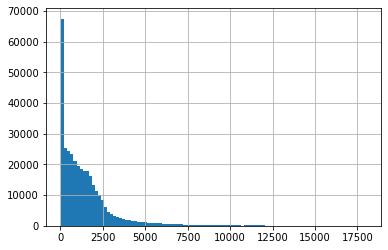

In [8]:
roundtrips = data[data["start station id"] == data["end station id"]]
print(f"There are {len(roundtrips)} round trips in the data")
roundtrips["tripduration"].hist(bins=100)

<AxesSubplot:>

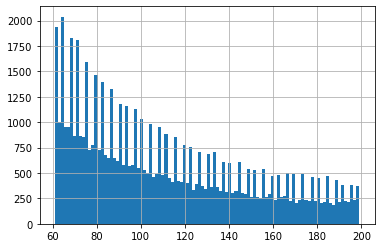

In [12]:
roundtrips[roundtrips["tripduration"]<200]["tripduration"].hist(bins=100)

Let us also exlcude round trips of less than 120 seconds.

In [15]:
shortroundtrips = roundtrips[roundtrips["tripduration"]<120]
print(f"There are {len(shortroundtrips)} short round trips in the data")
data.drop(shortroundtrips.index,inplace=True)

There are 38727 short round trips in the data


Let us furthermore indicate which trips are round trips for convenience

In [17]:
data["is_roundtrip"] = data["start station id"] == data["end station id"]
data["is_roundtrip"].value_counts()

False    17173650
True       306566
Name: is_roundtrip, dtype: int64

In [20]:
data.to_csv(savepath)

## Computing some more features

In [3]:
data = pd.read_csv(savepath)

There are some features that seem intuitively obvious to compute, such as the distane traveled, the speed of the bikes, whether it is a workday or weekend, and whether it is summer or winter.
We do this for the whole data set.
Note that we do not use any information about the labels here, so we do not need a train / test split yet.

Compute Haversine distance between start and end point

In [16]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Taken from https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
    
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = (6367 * c)*1000
    return m

In [15]:
haversine(data.iloc[0]["start station longitude"], data.iloc[0]["start station latitude"], data.iloc[0]["end station longitude"], data.iloc[0]["end station latitude"])
#google maps claims about 850 m

820.1532646056683

In [ ]:
data["haversine distance"] = haversine(data["start station longitude"], data["start station latitude"], data["end station longitude"], data["end station latitude"])

In [29]:
data.to_csv(savepath)

In [4]:
data = pd.read_csv(savepath)

In [5]:
data.memory_usage(deep=True)

Index                             128
Unnamed: 0                  139841728
tripduration                139841728
starttime                  1415897496
stoptime                   1415897496
start station id            139841728
start station name         1338558978
start station latitude      139841728
start station longitude     139841728
end station id              139841728
end station name           1337897909
end station latitude        139841728
end station longitude       139841728
bikeid                      139841728
usertype                   1167347722
birth year                  139841728
gender                      139841728
month                       139841728
is_roundtrip                 17480216
haversine distance          139841728
dtype: int64

In [18]:
data["start station name"] = data["start station name"].astype("category")
data["end station name"] = data["end station name"].astype("category")
data["usertype"] = data["usertype"].astype("category")
data["gender"] = data["gender"].astype("category")
data["month"] = data["month"].astype("category")

In [20]:
data.memory_usage(deep=True)

Index                             128
Unnamed: 0                  139841728
tripduration                139841728
starttime                  1415897496
stoptime                   1415897496
start station id            139841728
start station name           35056717
start station latitude      139841728
start station longitude     139841728
end station id              139841728
end station name             35058670
end station latitude        139841728
end station longitude       139841728
bikeid                      139841728
usertype                     17480456
birth year                  139841728
gender                       17480348
month                        17480612
is_roundtrip                 17480216
haversine distance          139841728
usertpe                      35058670
dtype: int64

Next we compute weekdays

In [22]:
def strtodatetime(s):
    """
    Take a string in the format of the data  set and return a datetime object
    """
    s = s.split(".")[0]
    d=datetime.datetime.strptime(s,"%Y-%m-%d %H:%M:%S")
    return d.day, d.hour, d.minute, d.weekday()

In [31]:
new = data[["starttime"]].apply(lambda row: strtodatetime(row["starttime"]),axis=1,result_type="expand")

MemoryError: 

## Splitting the Data

We now split the data in a 60/20/20 ratio of training/validation/test.

In [8]:
print(len(data))
n = len(data)
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2
train_size = int(train_ratio*n)
val_size = int(val_ratio*n)
test_size = int(test_ratio*n)
print("Train: {0}, Val: {1}, Test: {2}".format(int(train_ratio*n), int(val_ratio*n), int(test_ratio*n)))

17548339
Train: 10529003, Val: 3509667, Test: 3509667


In [9]:
trainset,testset = train_test_split(data,test_size=test_size)
trainset,valset = train_test_split(trainset,test_size=val_size)
print(len(trainset),len(valset),len(testset))

10529005 3509667 3509667


In [10]:
with open("Data/Train.csv","w") as file:
    trainset.to_csv(file)

In [11]:
with open("Data/Validation.csv","w") as file:
    valset.to_csv(file)

In [12]:
with open("Data/Test.csv","w") as file:
    testset.to_csv(file)